Pneumonia is inflammation of the lungs, usually caused by an infection. Most people get better in 2 to 4 weeks, but babies, older people, and people with heart or lung conditions are at risk of getting seriously ill and may need treatment in hospital.

Symptoms of pneumonia can start suddenly or gradually over a few days.

Pneumonia detection is most common performed by diagnostic imaging study. However, several factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR, complicating interpretation further. In addition, clinicians are faced with reading high volumes of images every shift. 

In this project, you are challenged to design and implement a deep learning algorithm to detect pneumonia from medical images.

# Imports 

In [1]:
#!pip install torch torchvision tensorflow opencv-python matplotlib pandas imbalanced-learn

In [2]:
import torchvision, torch, os, shutil, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchsampler import ImbalancedDatasetSampler
from PIL import Image
from torchvision import transforms, datasets
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision.transforms import transforms
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image

/home/kacper/.local/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Pre-EDA checks

First of all, I'd like to check whether or not my device is able to use a GPU for the calculations, or will I be solely reliant on my CPU. 

In [3]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Get number of CPU cores
num_cpu_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cpu_cores}")

# Get GPU name
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU name: {gpu_name}")
else:
    print("No GPU available")

Device: cpu
Number of CPU cores: 12
No GPU available


I will have to utilize my CPU for the calculations (Ryzen 1600). 
This is not a powerful CPU, and in order to complete this task, I will need to utilize methods that take less processing power.

# Exploratory Data Analysis

## Kaggle

Before even loading the data, I've had a look at what others have done with this Kaggle dataset. One interesting fact that I've seen noticed is the validation data being too small relative to the size of the complete dataset, which will need to be investigated. The discussions mentioning this are as follows:
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/discussion/122816?resource=download&sort=votes

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/discussion/183643

## Data Loading

In [4]:
# Path leading to dataset
main_path = '/home/kacper/chest_xray/'
os.listdir(main_path)

['test', 'chest_xray', 'val', 'train']

In [5]:
# Paths to folders inside 
test_dataset = main_path + 'test'
train_dataset = main_path + 'train'
val_dataset = main_path + 'val'
chest_xray_folder = main_path + 'chest_xray'

In [6]:
os.listdir(chest_xray_folder)

['test', 'val', 'train']

chest_xray folder seems to just be a copy of the other three folders. We will thus ignore it and simply utilize the remaining three.

## Params 
These params will be used throughout the process, thus they need to be at the top to ensure they work with the rest of the code below.

In [7]:
params = {
    'epoch_number' : 10,
    'batch_size' : 128,
    'learning_rate' : 0.001,
    'image_size' : 256
    }

## Data Transformations
These data transforms are also retroactively contained here, so that I can utilize them during the data loading process, as I wish to create two datasets, one almost unaltered, and the second one being heavily modified, to gain a better understanding of how big of an improvements those changes made. It is also suggested that the sampler that I will utlized works best in tandem with data augmentation.

In [8]:
#The first data transforms is applied to the original dataset just to ensure it is turned into a tensor and that 
#it is resized.
initial_data_transforms = transforms.Compose([
    transforms.Resize(size=(params["image_size"], params["image_size"])),
    transforms.ToTensor(),
])

data_transforms = transforms.Compose([
    transforms.Resize(size=(params["image_size"], params["image_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

data_transforms_train = transforms.Compose([
    transforms.RandomRotation(20),  # Randomly rotate the image within a range of (-20, 20) degrees
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with 50% probability
    transforms.RandomResizedCrop(size=(params["image_size"], params["image_size"]), scale=(0.8, 1.0)),  # Randomly crop the image and resize it
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Randomly change the brightness, contrast, saturation, and hue
    transforms.RandomApply([transforms.RandomAffine(0, translate=(0.1, 0.1))], p=0.5),  # Randomly apply affine transformations with translation
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=0.5),  # Randomly apply perspective transformations
    transforms.Resize(size=(params["image_size"], params["image_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

In [9]:
# Load the datasets
train = datasets.ImageFolder(train_dataset, transform=initial_data_transforms)
test = datasets.ImageFolder(test_dataset, transform=initial_data_transforms)
# val = datasets.ImageFolder(val_dataset, transform=data_transforms) # TODO, implement validation testing

train2 = datasets.ImageFolder(train_dataset, transform=data_transforms_train)
test2 = datasets.ImageFolder(test_dataset, transform=data_transforms)


## Data Visualisation

In [10]:
def visualize_class_distribution(dataset, dataset_name):
    class_counts = np.zeros(len(dataset.classes))
    for _, y in dataset:
        class_counts[y] += 1

    plt.bar(dataset.classes, class_counts)
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title(f"Class distribution in the {dataset_name} dataset")
    plt.show()

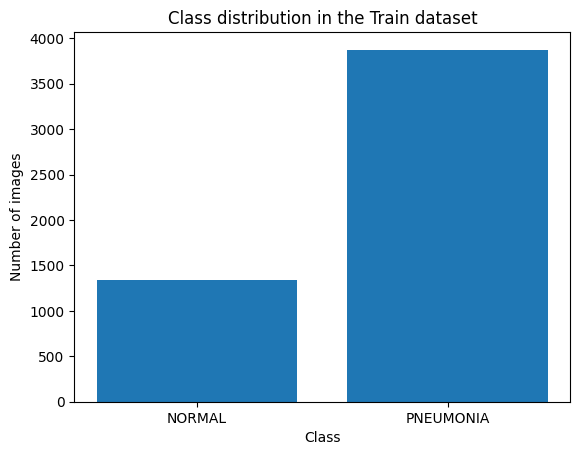

In [11]:
visualize_class_distribution(train, "Train")

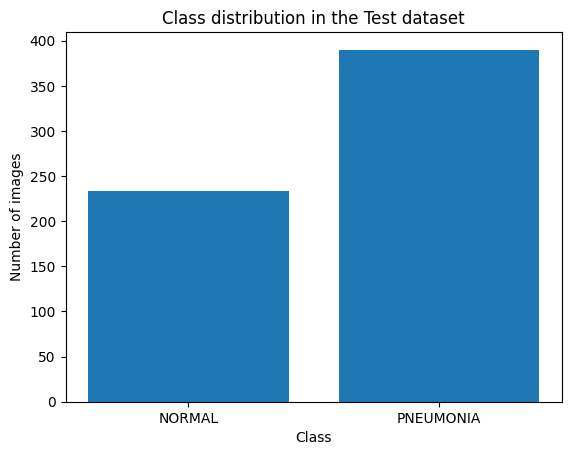

In [12]:
visualize_class_distribution(test, "Test")

In [13]:
len(train)

5216

In [14]:
len(test)

624

In [15]:
def display_random_images(dataset, num_images=5):
    dataset_size = len(dataset)

    random_indices = np.random.choice(dataset_size, num_images, replace=False)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i, index in enumerate(random_indices):
        image_tensor = dataset[index][0]
        image_array = image_tensor.numpy()
        image_array = np.transpose(image_array, (1, 2, 0))
        axes[i].imshow(image_array)
        axes[i].axis('off')

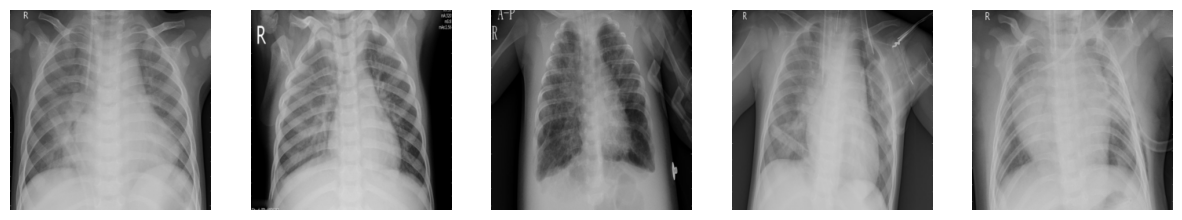

In [16]:
display_random_images(train,5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


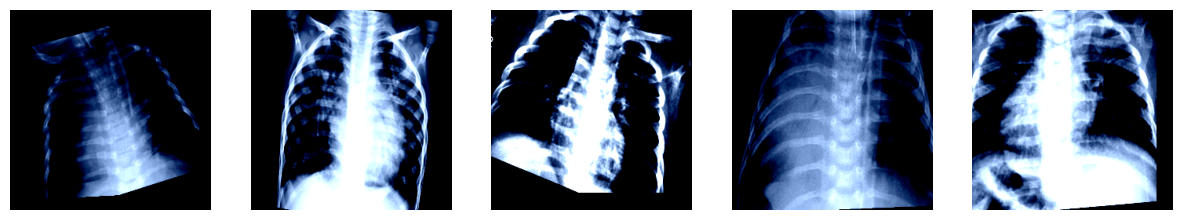

In [17]:
display_random_images(train2,5)

As we can see from the following charts above:

    There is a class imbalance, with pneumonia being the majority class in both training and test data.

In order to balance the data, I have many methods I could use, such as Undersampling or Data Augmentation. I will however use ImbalancedDatasetSampler available from github.

I should also compare the scores with the unbalanced dataset, thus I will create two more datasets, and two of them will be balanced (train2 and test2), and two will not(train and test).

https://github.com/ufoym/imbalanced-dataset-sampler The description of it goes as follows: 

In this repo, we implement an easy-to-use PyTorch sampler ImbalancedDatasetSampler that is able to:

    rebalance the class distributions when sampling from the imbalanced dataset
    estimate the sampling weights automatically
    avoid creating a new balanced dataset
    mitigate overfitting when it is used in conjunction with data augmentation techniques

Hence the extensive data augmentation we used on train2 and test2 earlier on. 

# Modelling

In [18]:
#Load the data with dataloader
train_loader = torch.utils.data.DataLoader(train, batch_size=params["batch_size"], shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test, batch_size=params["batch_size"], shuffle=True, num_workers=4)
sampled_train_loader = torch.utils.data.DataLoader(train2, batch_size=params["batch_size"], shuffle=True, num_workers=4)
sampled_test_loader = torch.utils.data.DataLoader(test2, batch_size=params["batch_size"], shuffle=True, num_workers=4)

In [22]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(16 * 128 * 128, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 2)
)

In [23]:
# Create an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

## Training unchanged dataset

Epoch [1]: Train Loss: 4.4992
Epoch [2]: Train Loss: 0.2370
Epoch [3]: Train Loss: 0.1723
Epoch [4]: Train Loss: 0.0966
Epoch [5]: Train Loss: 0.0789
Epoch [6]: Train Loss: 0.0694
Epoch [7]: Train Loss: 0.0526
Epoch [8]: Train Loss: 0.0483
Epoch [9]: Train Loss: 0.0445
Epoch [10]: Train Loss: 0.0381


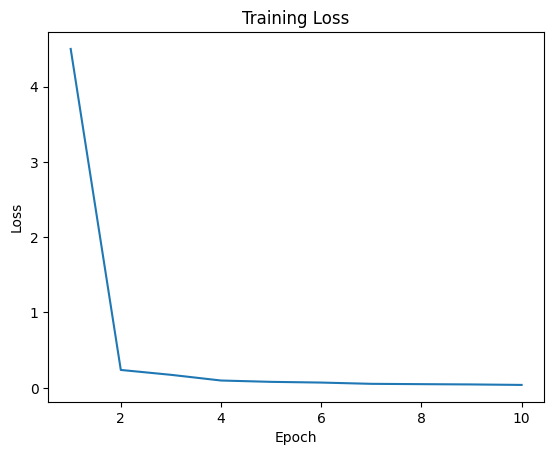

Accuracy on the test set: 76.92%


In [24]:
# Lists to store the epoch numbers and corresponding losses
epoch_nums = []
loss_values = []

model.train()
for epoch in range(params['epoch_number']):
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
 
    epoch_loss = running_loss / len(train_loader)
    epoch_nums.append(epoch + 1)
    loss_values.append(epoch_loss)
    print(f"Epoch [{epoch + 1}]: Train Loss: {epoch_loss:.4f}")  

# Plotting the loss graph
plt.plot(epoch_nums, loss_values)  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.title('Training Loss')  
plt.show() 

# Evaluate the model on the test set
correct = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {correct / len(test):.2%}")

## Training changed dataset

Epoch [1]: Train Loss: 2.8644
Epoch [2]: Train Loss: 0.3296
Epoch [3]: Train Loss: 0.2481
Epoch [4]: Train Loss: 0.2417
Epoch [5]: Train Loss: 0.2354
Epoch [6]: Train Loss: 0.2191
Epoch [7]: Train Loss: 0.2178
Epoch [8]: Train Loss: 0.2097
Epoch [9]: Train Loss: 0.2143
Epoch [10]: Train Loss: 0.2145


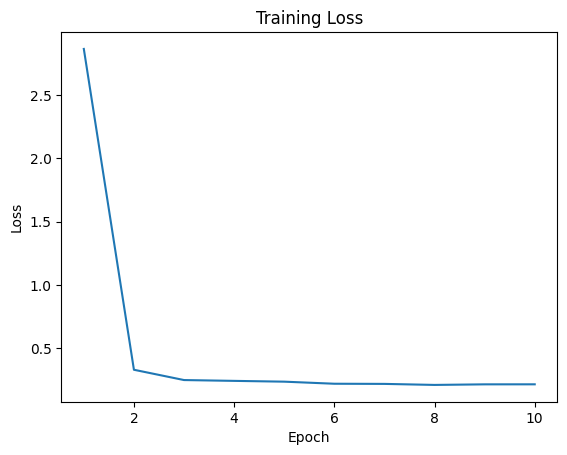

Accuracy on the test set: 87.66%


In [25]:
# Lists to store the epoch numbers and corresponding losses
epoch_nums = []
loss_values = []

model.train()
for epoch in range(params['epoch_number']):
    running_loss = 0.0

    for inputs, labels in sampled_train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
 
    epoch_loss = running_loss / len(sampled_train_loader)
    epoch_nums.append(epoch + 1)
    loss_values.append(epoch_loss)
    print(f"Epoch [{epoch + 1}]: Train Loss: {epoch_loss:.4f}")  
    

# Evaluate the model on the test set
correct = 0
model.eval()
with torch.no_grad():
    for images, labels in sampled_test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        
# Plotting the loss graph
plt.plot(epoch_nums, loss_values)  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.title('Training Loss')  
plt.show() 
print(f"Accuracy on the test set: {correct / len(test):.2%}")

## F1 Score and confusion matrix
The F1 score is a metric commonly used in binary classification tasks to evaluate the performance of a model. It combines precision and recall into a single value, providing a balanced measure of the model's accuracy.

Precision is the ratio of true positive predictions to the total number of positive predictions made by the model. It represents the model's ability to correctly identify positive instances.

Recall, also known as sensitivity or true positive rate, is the ratio of true positive predictions to the total number of actual positive instances in the dataset. It measures the model's ability to correctly identify all positive instances.

The F1 score is the harmonic mean of precision and recall. It takes into account both false positives (incorrectly predicted positive instances) and false negatives (positive instances that were missed by the model). By combining precision and recall, the F1 score provides a single value that represents the overall performance of the model.

Confusion matrix is a visual way of representing the values later utilized in the F1 score, and I will use it as well.

## Checking unchanged dataset

In [26]:
# Initialize empty lists to store true labels and predictions
true_labels = []
predicted_labels = []
correct = 0

# Accumulate true labels and predictions for all mini-batches in the test set
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
        correct += (predicted == labels).sum().item()

# Calculate precision, recall, and F1 score using the accumulated true labels and predictions
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1:.2f}")

Precision: 0.88, Recall: 0.73, F1 score: 0.80


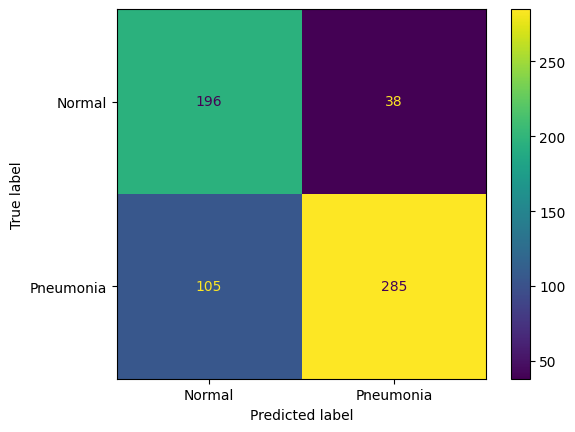

In [27]:
# Calculate the confusion matrix using the accumulated true labels and predictions
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot()

## Checking changed dataset

In [28]:
# Initialize empty lists to store true labels and predictions
true_labels = []
predicted_labels = []
correct = 0

# Accumulate true labels and predictions for all mini-batches in the test set
with torch.no_grad():
    for images, labels in sampled_test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
        correct += (predicted == labels).sum().item()

# Calculate precision, recall, and F1 score using the accumulated true labels and predictions
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1:.2f}")

Precision: 0.91, Recall: 0.89, F1 score: 0.90


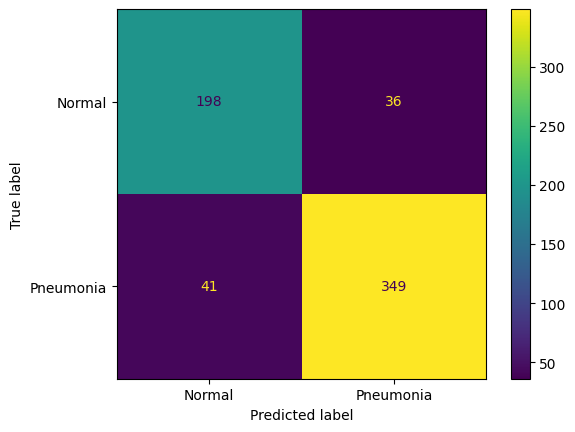

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix using the accumulated true labels and predictions
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot()

# Tests

The model for these tests looks like so:

model = torch.nn.Sequential(

    torch.nn.Flatten(),

    torch.nn.Linear(3 * params['image_size'] * params['image_size'], 512),

    torch.nn.ReLU(),

    torch.nn.Linear(512, 2)

    
)


It simply flattens the data into a 1-dimensional vector. Afterwards, a linear layer maps this input of size 3 * image_size * image_size to a hidden layer of 512 (simply an amount of neurons the network has) and this is where the weights and biases are learnt.

Next, it goes through an activation function, in this case ReLU. Then, the final output is created through another linear layer that maps the output of 512 from the previous layer into the amount of classes that were declared in params.

## Standard Params
Params for this test are as follows:

Number of Epochs = 10

Batch Size = 64

Learning Rate = 0.001

Image Size = 256

The results were as follows:

### Unchanged Dataset

The unchanged dataset had an accuracy of 73.56%. The loss went from 9.0055 to 0.2782 and from then stagnated, going down to 0.1292 in the additional 8 epochs.

Confusion matrix and F1 scores showed the major problem with the model, with:

Precision = 0.62

Recall = 1


F1 score = 0.77

However, the confusion matrix showed us that the model classified ALL pictures as Pneumonia, with 0 being predicted as normal. This essentially makes the model good for nothing on this dataset

### Changed Dataset

The changed dataset had an accuracy of 80.45%. The loss went from 14.2292 to 0.4173 and from then stagnated, going down to 0.3080 in the additional 8 epochs. 

Confusion matrix and F1 scores:

Precision = 0.79

Recall = 0.94

F1 score = 0.86

The confusion matrix gave us the following:

TP = 135

FP = 23

FN = 99

TN = 367


### Conclusion

The changed dataset gave us a much better score than the unchanged dataset, and it is actually capable of determining whether or not an image contains pneumonia or not, with a reasonably good accuracy.

## Increased epoch count

In this test, I've increased the epoch number to 20, giving us the following params:

Number of Epochs = 20

Batch Size = 64

Learning Rate = 0.001

Image Size = 256

The results were as follows:

### Unchanged Dataset

The unchanged dataset had an accuracy of 70.51%. The loss went from 14.0130 to 0.7236 and from then to 0.1756 in epoch 10, and then going down to 0.0965 in the additional 10 epochs. There were bumps up throughout the way, for instance between epoch 7 and 8 the loss went from 0.2064 to 0.5178

Confusion matrix and F1 scores showed the major problem with the model, being the same as the last time:

Precision = 0.62

Recall = 1

F1 score = 0.77

The confusion matrix is also the same as last time, with 234 normal cases being labeled as Pneumonic (False Negatives), and the 390 Pneumonic cases as Pneumonic (True Negatives). None were labelled as positives, either true or false.

### Changed Dataset

The changed dataset had an accuracy of 80.77%. The loss went from 16.1928 to 0.5508 and from then went down to 0.3035 in epoch 10, and to 0.2822 in the additional 10 epochs. 

Confusion matrix and F1 scores:

Precision = 0.79

Recall = 0.95

F1 score = 0.86

The confusion matrix gave us the following:

TP = 133

FP = 19

FN = 101

TN = 371

### Conclusion
Increasing epoch count does not impact the model in any significant way, as the unchanged dataset had no improvements to it, and changed dataset had an only slight bump to its F1 score.

## Decreased data batch size
In this test, I've decreased the batch size from 64 to 32, with params looking like this:

Number of Epochs = 10

Batch Size = 32

Learning Rate = 0.001

Image Size = 256

The results were as follows:

### Unchanged Dataset

The unchanged dataset had an accuracy of 71.98%. The loss went from 4.1860 to 0.5435 and from then slowed down, going down to 0.1110 in the additional 8 epochs. 

Confusion matrix and F1 scores show us that the predictions started to improve, with:

Precision = 0.66

Recall = 0.99

F1 score = 0.80

The confusion matrix gave us the following:

TP = 36

FP = 2

FN = 198

TN = 388


### Changed Dataset

The changed dataset had an accuracy of 83.33%. The loss went from 11.1540 to 0.4440 and from then went down to 0.3255 in epoch 10.

Confusion matrix and F1 scores:

Precision = 0.79

Recall = 0.95

F1 score = 0.86

The confusion matrix gave us the following:

TP = 182

FP = 52

FN = 52

TN = 338


### Conclusion

Decreasing batch size gave us significant improvements to both unchanged and changed datasets, with unchanged dataset starting to be able to detect positives, whilst changed dataset achieved better metrics. 

## Increased Learning Rate

In this test, I've significantly increase the learning rate, from 0.001 to 0.1. 

### Both Datasets and conclusions

This has yielded terrible results. 

In unchanged dataset, the initial loss was 3316.4417, but it managed to stabilize to 0.5703 at epoch 10. 

In changed dataset, the initial loss was 46479.3962, and it managed to reach 0.9633 at epoch 10, but in previous epochs it was jumping between values in ranges of 50 and 400.

Both dataset contains almost exactly the same confusion matrices and f1 scores, with the scores being:

Precision = 0.62

Recall = 1

F1 score = 0.77

The confusion matrix labelled ALL pictures as pneumonic in both datasets. 

### Conclusion

The learning rate being too high can utterly destroy your model predictions, and thus should be adjusted more carefully.

## Increased Image size

In this test, I've significantly increased the image size, from 256 to 512. 

### Unchanged Dataset

The unchanged dataset had an accuracy of 80.77%. The loss went from 35.2648 to 1.1943 and from then stagnated, going down to 0.3308 in the additional 8 epochs.

Confusion matrix and F1 scores showed the major problem with the model, with:

Precision = 0.62

Recall = 1

F1 score = 0.77

However, the confusion matrix showed us that the model classified ALL pictures as Pneumonia, with 0 being predicted as normal. This essentially makes the model good for nothing on this dataset.

### Changed Dataset

The changed dataset had an accuracy of 83.33%. The loss went from 128.2825 to 0.4440 and from then went down to 0.3861 in epoch 10.

Confusion matrix and F1 scores:

Precision = 0.90

Recall = 0.77

F1 score = 0.83

The confusion matrix gave us the following:

TP = 200

FP = 91

FN = 34

TN = 299

As we can see, this time the precision is higher than recall on this training. 

## Increased model complexity

In this test, I've added two additional layers to the network, a conv2d and a maxpool. Conv2d adds a convolutional layer which adds additional layers to an image (in this case, from 3 to 16). Those 16 layers are intent on scanning the image for edges, colours, textures etc. to learn more about it. The next thing is maxpool. Maxpool makes the image smaller by finding the most important values inside its kernel.
The updated model looks like this:

model = torch.nn.Sequential(

    torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    
    torch.nn.MaxPool2d(kernel_size=2, stride=2),

    torch.nn.Flatten(),
    
    torch.nn.Linear(16 * 128 * 128, 512),
    
    torch.nn.ReLU(),
    
    torch.nn.Linear(512, 2)
    
)

### Unchanged Dataset

The unchanged dataset had an accuracy of 76.92%. The loss went from 4.4992 to 0.2370, and from there it slowly crept down to 0.0381 

Confusion matrix and F1 scores:

Precision = 0.88

Recall = 0.73

F1 score = 0.80

The confusion matrix gave us the following:

TP = 196

FP = 38

FN = 105

TN = 285

### Changed Dataset

The changed dataset had an accuracy of 87.66%. The loss went from 2.8644 to 0.3296 and from then went down to 0.2145 in epoch 10.

Confusion matrix and F1 scores:

Precision = 0.91

Recall = 0.89

F1 score = 0.90

The confusion matrix gave us the following:

TP = 198

FP = 36

FN = 41

TN = 349

As we can see, this time the precision is higher than recall on this training. 

## Conclusion 

As our tests have proven, making the batch size smaller seems to yield better predictions, while increasing epoch number did not provide a significant improvement to the model, while operations such as increasing image size seems to twist the statistics. 

An improved model shows a large increase of accuracy and f1 score, despite just two layers more. 

Interestingly, in the unchanged datasets, despite no difference in the confusion matrix, the accuracies seem to differ on each test.